# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print("Number of rows and columns for azdias is: {}".format(azdias.shape))

print("Head row for azdias:")
azdias.head()

Number of rows and columns for azdias is: (891221, 85)
Head row for azdias:


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
print("Number of rows and columns for feat_info is: {}".format(feat_info.shape))

print("Head row for feat_info:")
feat_info.head()

Number of rows and columns for feat_info is: (85, 4)
Head row for feat_info:


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [27]:
# Convert missing values into NaN
def convert_missing_values(dataframe):
    
    # Iterate on each attribute column
    for attribute in feat_info['attribute']:

        # Obtain missing values for the respective attribute column
        missing_values = feat_info[feat_info['attribute'] == attribute].missing_or_unknown.iloc[0]

        # Convert missing values into a list
        missing_values_list = missing_values.strip('][').split(',')

        # Convert missing numeric values into floats
        missing_values_list = [float(x) if x.lstrip('-').isnumeric() else x for x in missing_values_list]

        # Convert missing values to NaN 
        dataframe[attribute].replace(to_replace=missing_values_list,value=np.NaN, inplace=True)

In [28]:
# Identify missing or unknown data values and convert them to NaNs.

# Convert missing values into NaN
convert_missing_values(azdias)

azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [29]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Count how much missing data is present in each column
missing_data_columns = azdias.isnull().sum().sort_values(ascending=False)

missing_data_columns

TITEL_KZ         889061
AGER_TYP         685843
KK_KUNDENTYP     584612
KBA05_BAUMAX     476524
GEBURTSJAHR      392318
                  ...  
SEMIO_DOM             0
SEMIO_KAEM            0
SEMIO_PFLICHT         0
SEMIO_TRADV           0
ZABEOTYP              0
Length: 85, dtype: int64

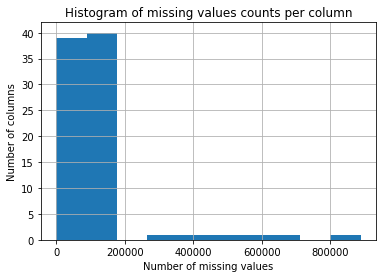

In [30]:
# Investigate patterns in the amount of missing data in each column.

# Show histogram to visualize the distribution of missing value counts
missing_data_columns.hist()

plt.xlabel('Number of missing values')
plt.ylabel('Number of columns')
plt.title('Histogram of missing values counts per column')
plt.grid(True)
plt.show()

In [31]:
# Maximum number of missing values allowed.
# This value was calculated based on the histogram above, where most of the features
# have less than 200000 missing values (except for the outliers).
max_missing_values = 200000

# Count how much missing data is present in each column
missing_data_columns = azdias.isnull().sum().sort_values(ascending=False)

# Obtain outliers column names
outliers_features = list(missing_data_columns[missing_data_columns > max_missing_values].index)

print("Number of outliers columns to remove: {}".format(len(outliers_features)))
print("Outliers columns names: {}".format(outliers_features))

Number of outliers columns to remove: 6
Outliers columns names: ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']


In [32]:
# Remove the outlier columns from the dataset
def remove_outliers_columns(dataframe):

    # Remove outliers columns from the dataset
    dataframe.drop(outliers_features, axis='columns', inplace=True)

In [33]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Remove outliers columns from the dataset
remove_outliers_columns(azdias)

azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

**Answer**
Looking at the histogram above, most of the features have less than 200000 missing values, except for the outliers that were removed from the dataframe.

These 6 outliers are:
  * TITEL_KZ
  * AGER_TYP
  * KK_KUNDENTYP
  * KBA05_BAUMAX
  * GEBURTSJAHR
  * ALTER_HH

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [34]:
# How much data is missing in each row of the dataset?

# Count how much missing data is present in each row
missing_data_rows = azdias.isnull().sum(axis=1).sort_values(ascending=False)

missing_data_rows

643174    49
732775    49
472919    48
183108    47
139316    47
          ..
540280     0
540277     0
540275     0
540274     0
445610     0
Length: 891221, dtype: int64

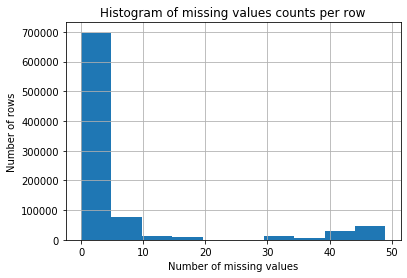

In [35]:
# Show histogram to visualize the distribution of missing value counts
missing_data_rows.hist()

plt.xlabel('Number of missing values')
plt.ylabel('Number of rows')
plt.title('Histogram of missing values counts per row')
plt.grid(True)
plt.show()

In [36]:
# Divide the data into two subsets based on the number of missing
# values in each row 
def missing_rows_subsets(dataframe):
    # Count how much missing data is present in each row
    missing_data_rows = dataframe.isnull().sum(axis=1).sort_values(ascending=False)

    # Maximum number of missing values allowed for rows.
    # This value was calculated based on the histogram above, where most of the rows
    # have less than 20 missing values (except for the outliers).
    threshold = 20

    # Contain only rows below the threshold (few missing values)
    below_threshold = dataframe[missing_data_rows < threshold].reset_index(drop=True)

    # Contain only rows above the threshold (high missing values)
    above_threshold = dataframe[missing_data_rows >= threshold].reset_index(drop=True)
    
    return below_threshold, above_threshold

In [37]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Contain rows below and above the threshold (high missing values)
below_threshold, above_threshold = missing_rows_subsets(azdias)

C:\Users\luvalverde\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\luvalverde\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


In [38]:
# Do some analysis based on the number of rows with few or high missing values

# Total number of rows
total_number_rows = len(azdias)

# Calculate total number of rows with few and high missing values
number_few_missing_values = len(below_threshold)
number_high_missing_values = len(above_threshold)

# Calculate percentages of rows with few and high missing values
few_missing_values_percentage = (number_few_missing_values*100)/total_number_rows
high_missing_values_percentage = (number_high_missing_values*100)/total_number_rows

print("Total number of rows: {}".format(total_number_rows))
print("There are {} rows with few missing values ({:.2f}%)".format(number_few_missing_values, few_missing_values_percentage))
print("There are {} rows with high missing values ({:.2f}%)".format(number_high_missing_values, high_missing_values_percentage))

Total number of rows: 891221
There are 797077 rows with few missing values (89.44%)
There are 94144 rows with high missing values (10.56%)


In [39]:
below_threshold.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
1,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
2,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
3,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
4,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [40]:
above_threshold.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


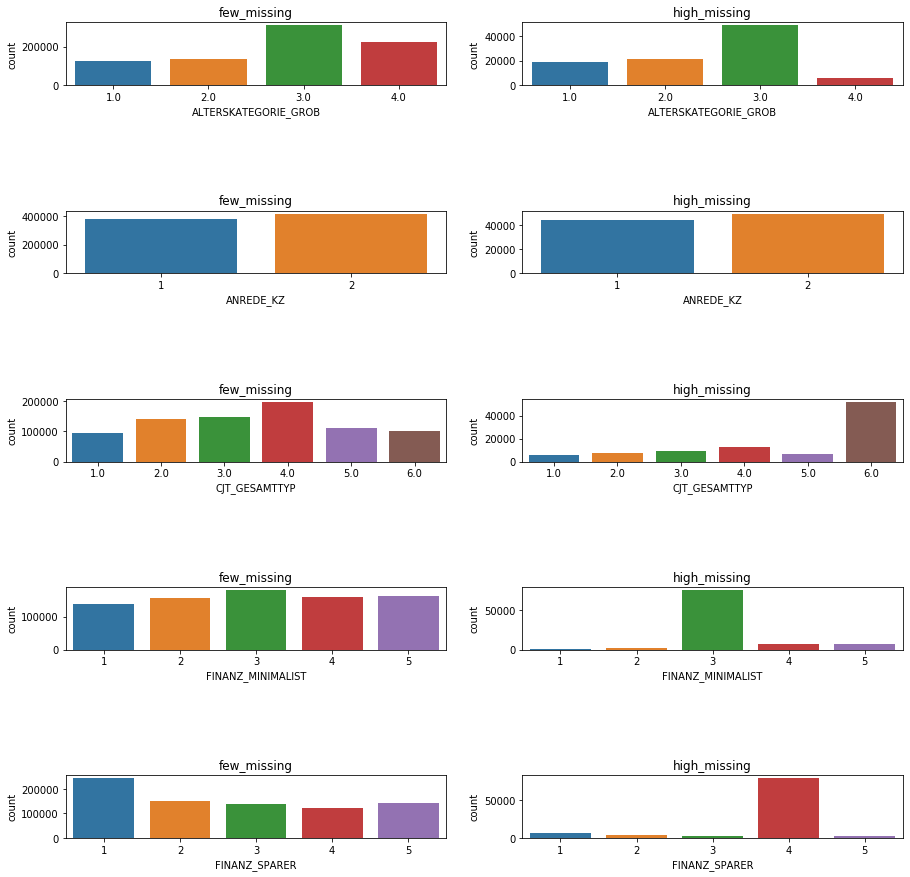

In [41]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def show_distribution_graphs(number_columns_to_show):
    ''' Shows the distribution of values for a certain number of columns where there are
        no or few missing values, between the two subsets.
    '''
    
    # Columns names to compare the distribution of values
    column_names = below_threshold.columns
    
    fig, axs = plt.subplots(number_columns_to_show, 2, figsize=(15, 15))
    fig.subplots_adjust(hspace =2 , wspace=.2)
    axs = axs.ravel()

    # Iterate through each of the columns names
    for column_index in range(number_columns_to_show):
    
        sns.countplot(below_threshold[column_names[column_index]], ax=axs[column_index*2])
        axs[column_index*2].set_title('few_missing')
        
        sns.countplot(above_threshold[column_names[column_index]], ax=axs[column_index*2+1])
        axs[column_index*2+1].set_title('high_missing')
    

# Number of columns to compare the distribution of values
number_columns_to_show = 5

show_distribution_graphs(number_columns_to_show)

In [42]:
# New data subset to use
data_subset = below_threshold.copy()

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

**Answer:**

Looking at the histogram above, most of the rows have less than 20 
missing values, that is why a threshold of 20 was defined.

After dividing the data into two subsets (few and high missing values), 
and plotting the distribution of data values, it seems that the data with high
missing values does not look very different from the data with few missing values. 
Therefore, dropping those points with high missing values from the analysis won't present a major issue; besides, it only constitutes the 10.56% of the total amount of rows.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [43]:
# How many features are there of each data type?

feat_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [44]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Obtain categorical columns names
categorical_columns = feat_info[feat_info['type']=='categorical'].attribute

categorical_columns

0             AGER_TYP
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
40            TITEL_KZ
41            VERS_TYP
42            ZABEOTYP
47        KK_KUNDENTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [45]:
# Identify categorical features
def identify_categorical_features(dataframe):
    pretty_printer = pprint.PrettyPrinter()

    for column_name in categorical_columns:
        # Identify binary columns
        if column_name in dataframe and dataframe[column_name].nunique() <= 2:
            binary_columns[column_name] = dataframe[column_name].unique()

        # Identify multi-level columns
        elif column_name in dataframe:
            multi_columns[column_name] = dataframe[column_name].unique()
            
    print("Binary columns\n")
    pretty_printer.pprint(binary_columns)
    
    print("Multi-level columns\n")
    pretty_printer.pprint(multi_columns)
    
# Re-encode categorical features
def reencode_categorical_features(dataframe):
    # Standardize binary columns into 0 or 1
    # This columns was chosen because it takes on non-numeric values
    new_values = {'W': 0, 'O': 1}
    dataframe['OST_WEST_KZ'].replace(new_values, inplace=True)

    # Remove multi-level columns
    dataframe.drop(list(multi_columns.keys()), axis='columns', inplace=True)
    
    return dataframe

In [46]:
# Re-encode categorical variable(s) to be kept in the analysis.
binary_columns = {}
multi_columns = {}
identify_categorical_features(data_subset)

data_subset = reencode_categorical_features(data_subset)

Binary columns

{'ANREDE_KZ': array([2, 1], dtype=int64),
 'GREEN_AVANTGARDE': array([0, 1], dtype=int64),
 'OST_WEST_KZ': array(['W', 'O'], dtype=object),
 'SOHO_KZ': array([1., 0.]),
 'VERS_TYP': array([ 2.,  1., nan])}
Multi-level columns

{'CAMEO_DEUG_2015': array(['8', '4', '2', '6', '1', '9', '5', '7', nan, '3'], dtype=object),
 'CAMEO_DEU_2015': array(['8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '5C',
       '8B', '7A', '5D', '9E', nan, '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C'], dtype=object),
 'CJT_GESAMTTYP': array([ 5.,  3.,  2.,  4.,  1.,  6., nan]),
 'FINANZTYP': array([1, 6, 5, 2, 4, 3], dtype=int64),
 'GEBAEUDETYP': array([8., 1., 3., 2., 6., 4., 5.]),
 'GFK_URLAUBERTYP': array([10.,  1.,  5., 12.,  9.,  3.,  8., 11.,  4.,  2.,  7.,  6., nan]),
 'LP_FAMILIE_FEIN': array([ 5.,  1., nan, 10.,  2.,  7., 11., 

In [47]:
data_subset.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
1,3.0,2,1,4,1,2,3,5,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
2,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
3,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
4,1.0,2,3,1,5,2,2,5,0,3.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

**Answer:**
For binary variable that takes on non-numeric values, the step performed was to replace the non-numeric values for numeric ones.

And for multi-level categoricals, the step realized was to drop them.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [48]:
# Select mixed features names
mixed_features = feat_info[feat_info.type == 'mixed'].attribute

mixed_features

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
64             KBA05_BAUMAX
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [49]:
# Generation-decade mapping values
generations = {0: [1, 2],           # 40s
               1: [3, 4],           # 50s
               2: [5, 6, 7],        # 60s
               3: [8, 9],           # 70s
               4: [10, 11, 12, 13], # 80s
               5: [14, 15]}         # 90s

# Movement mapping values
mainstream = [1, 3, 5, 8, 10, 12, 14]

# Generation-decade mapping
def generation_mapping(value):
    mapped_value = value
    
    for key, values in generations.items():
        # Return key if value is in the generations list values
        if value in values:
            mapped_value = key
            break
            
    return mapped_value

# Movement mapping
def movement_mapping(value):
    mapped_value = 0
    
    # Return 1 if value is in the mainstream list values
    if value in mainstream:
        mapped_value = 1
    
    return mapped_value

In [50]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Mapping for wealth variable.
# It takes the 'tens'-place digit
def map_wealth(digits_code):
    # Obtain the code digit if not Nan
    if not pd.isnull(digits_code):
        digits_code = int(str(digits_code)[0])
    
    return digits_code

# Mapping for life stage variable
# It takes the 'ones'-place digit
def map_lifestage(digits_code):
    # Obtain the code digit if not Nan
    if not pd.isnull(digits_code):
        digits_code = int(str(digits_code)[1])
    
    return digits_code

In [51]:
# Engineer mixed type features
def engineer_mixed_types_features(dataframe):
    
    # Engineer generation column
    dataframe['PRAEGENDE_JUGENDJAHRE_GENERATION'] = dataframe['PRAEGENDE_JUGENDJAHRE'].apply(generation_mapping)

    # Engineer movement column
    dataframe['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = dataframe['PRAEGENDE_JUGENDJAHRE'].apply(movement_mapping)

    # Create wealth column mapping
    dataframe['CAMEO_INTL_2015_WEALTH'] = dataframe['CAMEO_INTL_2015'].apply(map_wealth)

    # Create life stage column mapping
    dataframe['CAMEO_INTL_2015_LIFESTAGE'] = dataframe['CAMEO_INTL_2015'].apply(map_lifestage)
    
    # Remove all mixed-features columns
    new_columns = list(set(dataframe.columns) - set(mixed_features))

    # Remove unneeded and the rest of mixed columns
    dataframe = dataframe[new_columns]
    
    return dataframe

In [52]:
# Engineer mixed type features
data_subset = engineer_mixed_types_features(data_subset)

In [53]:
data_subset['PRAEGENDE_JUGENDJAHRE_GENERATION'].head()

0    5.0
1    5.0
2    3.0
3    3.0
4    1.0
Name: PRAEGENDE_JUGENDJAHRE_GENERATION, dtype: float64

In [54]:
data_subset['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].head()

0    1
1    0
2    1
3    1
4    1
Name: PRAEGENDE_JUGENDJAHRE_MOVEMENT, dtype: int64

In [55]:
data_subset['CAMEO_INTL_2015_WEALTH'].head()

0    5.0
1    2.0
2    1.0
3    4.0
4    5.0
Name: CAMEO_INTL_2015_WEALTH, dtype: float64

In [56]:
data_subset['CAMEO_INTL_2015_LIFESTAGE'].head()

0    1.0
1    4.0
2    2.0
3    3.0
4    4.0
Name: CAMEO_INTL_2015_LIFESTAGE, dtype: float64

In [58]:
data_subset.head()

,PLZ8_HHZ,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,SEMIO_TRADV,SEMIO_KRIT,HEALTH_TYP,KBA05_ANTG2,SEMIO_MAT,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR,...,PRAEGENDE_JUGENDJAHRE_GENERATION,KBA05_ANTG4,PLZ8_ANTG4,SEMIO_ERL,GREEN_AVANTGARDE,OST_WEST_KZ,FINANZ_VORSORGER,ARBEIT,ANZ_HH_TITEL,GEBAEUDETYP_RASTER
0,5.0,9.0,11.0,6,4,3.0,0.0,3,963.0,1992.0,...,5.0,2.0,1.0,2,0,0,2,3.0,0.0,3.0
1,4.0,9.0,10.0,3,7,3.0,3.0,3,712.0,1992.0,...,5.0,0.0,0.0,6,1,0,1,3.0,0.0,4.0
2,3.0,9.0,1.0,4,4,2.0,1.0,1,596.0,1997.0,...,3.0,0.0,0.0,7,0,0,5,2.0,0.0,4.0
3,3.0,9.0,3.0,2,3,3.0,4.0,2,435.0,1992.0,...,3.0,0.0,1.0,4,0,0,4,4.0,0.0,5.0
4,5.0,9.0,5.0,6,4,3.0,2.0,4,1300.0,1992.0,...,1.0,0.0,1.0,2,0,0,5,2.0,0.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

**Answer:**
Engineering steps performed for some mixed feature columns:
 - "PRAEGENDE_JUGENDJAHRE": Two columns were created in order to map the generation and movement values.
 - "CAMEO_INTL_2015": Two columns were created in order to map the wealth and lifestage values.
 
Then, all mixed features were dropped from the dataset to simplify the process.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [59]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

print(data_subset.columns)

Index(['PLZ8_HHZ', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'SEMIO_TRADV',
       'SEMIO_KRIT', 'HEALTH_TYP', 'KBA05_ANTG2', 'SEMIO_MAT',
       'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR', 'CAMEO_INTL_2015_WEALTH',
       'ALTERSKATEGORIE_GROB', 'EWDICHTE', 'KBA05_GBZ', 'ONLINE_AFFINITAET',
       'ORTSGR_KLS9', 'FINANZ_MINIMALIST', 'SEMIO_DOM', 'BALLRAUM',
       'W_KEIT_KIND_HH', 'KKK', 'CAMEO_INTL_2015_LIFESTAGE', 'SEMIO_SOZ',
       'PLZ8_ANTG1', 'RELAT_AB', 'FINANZ_HAUSBAUER', 'HH_EINKOMMEN_SCORE',
       'PLZ8_ANTG3', 'SOHO_KZ', 'FINANZ_SPARER', 'SEMIO_REL', 'SEMIO_RAT',
       'ANZ_TITEL', 'SEMIO_PFLICHT', 'ANREDE_KZ', 'KBA05_ANTG3', 'SEMIO_FAM',
       'FINANZ_ANLEGER', 'SEMIO_KULT', 'SEMIO_KAEM', 'KONSUMNAEHE', 'REGIOTYP',
       'PLZ8_ANTG2', 'KBA05_ANTG1', 'RETOURTYP_BK_S', 'FINANZ_UNAUFFAELLIGER',
       'ANZ_PERSONEN', 'SEMIO_LUST', 'VERS_TYP', 'SEMIO_VERT', 'INNENSTADT',
       'PLZ8_GBZ', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT', 'MOBI_REGIO',
       'PRAEGENDE_JUGENDJAHRE_GENERATIO

In [60]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# None more steps should be performed. The data being used is the one with few missing values.
# Print dataframe for checking purposes
data_subset.head()

,PLZ8_HHZ,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,SEMIO_TRADV,SEMIO_KRIT,HEALTH_TYP,KBA05_ANTG2,SEMIO_MAT,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR,...,PRAEGENDE_JUGENDJAHRE_GENERATION,KBA05_ANTG4,PLZ8_ANTG4,SEMIO_ERL,GREEN_AVANTGARDE,OST_WEST_KZ,FINANZ_VORSORGER,ARBEIT,ANZ_HH_TITEL,GEBAEUDETYP_RASTER
0,5.0,9.0,11.0,6,4,3.0,0.0,3,963.0,1992.0,...,5.0,2.0,1.0,2,0,0,2,3.0,0.0,3.0
1,4.0,9.0,10.0,3,7,3.0,3.0,3,712.0,1992.0,...,5.0,0.0,0.0,6,1,0,1,3.0,0.0,4.0
2,3.0,9.0,1.0,4,4,2.0,1.0,1,596.0,1997.0,...,3.0,0.0,0.0,7,0,0,5,2.0,0.0,4.0
3,3.0,9.0,3.0,2,3,3.0,4.0,2,435.0,1992.0,...,3.0,0.0,1.0,4,0,0,4,4.0,0.0,5.0
4,5.0,9.0,5.0,6,4,3.0,2.0,4,1300.0,1992.0,...,1.0,0.0,1.0,2,0,0,5,2.0,0.0,4.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [61]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    convert_missing_values(df)
    
    # remove selected columns and rows, ...
    
    # Remove outliers columns from the dataset
    remove_outliers_columns(df)

    # Contain rows below and above the threshold (high missing values)
    below_threshold, _ = missing_rows_subsets(df)

    # select, re-encode, and engineer column values.

    # Re-encode categorical variable(s) to be kept in the analysis.
    new_data = reencode_categorical_features(below_threshold)

    # Engineer mixed type features
    new_data = engineer_mixed_types_features(new_data)

    # Return the cleaned dataframe.
    return new_data

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [62]:
# Perform feature scaling so that the principal component vectors are not influenced by the 
# natural differences in scale for features
def feature_scaling(dataframe):
    # If you've not yet cleaned the dataset of all NaN values, then investigate and
    # do that now.

    fill_missing = Imputer(strategy='median')
    clean_data = pd.DataFrame(fill_missing.fit_transform(dataframe))
    
    clean_data.columns = dataframe.columns
    clean_data.index = dataframe.index
    
    # Apply feature scaling to the data.
    clean_data_scaled = scaler.fit_transform(clean_data)
    
    clean_data_scaled = pd.DataFrame(clean_data_scaled, columns=list(clean_data))
    
    return clean_data_scaled

In [63]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()

azdias_scaled = feature_scaling(data_subset)

C:\Users\luvalverde\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [64]:
azdias_scaled.head()

,PLZ8_HHZ,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,SEMIO_TRADV,SEMIO_KRIT,HEALTH_TYP,KBA05_ANTG2,SEMIO_MAT,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR,...,PRAEGENDE_JUGENDJAHRE_GENERATION,KBA05_ANTG4,PLZ8_ANTG4,SEMIO_ERL,GREEN_AVANTGARDE,OST_WEST_KZ,FINANZ_VORSORGER,ARBEIT,ANZ_HH_TITEL,GEBAEUDETYP_RASTER
0,1.430188,0.566381,0.171252,1.288519,-0.311629,1.095917,-1.030429,-0.463253,1.020325,-0.383149,...,1.172665,2.728773,0.406890,-1.435509,-0.530654,-0.517521,-1.040664,-0.166703,-0.125151,-0.799699
1,0.391039,0.566381,0.107244,-0.410737,1.393241,1.095917,1.437609,-0.463253,0.276734,-0.383149,...,1.172665,-0.464432,-0.984749,0.754224,1.884467,-0.517521,-1.766903,-0.166703,-0.125151,0.283625
2,-0.648109,0.566381,-0.468831,0.155682,-0.311629,-0.257476,-0.207749,-1.508398,-0.066918,1.139883,...,-0.223457,-0.464432,-0.984749,1.301657,-0.530654,-0.517521,1.138052,-1.170257,-0.125151,0.283625
3,-0.648109,0.566381,-0.340815,-0.977156,-0.879919,1.095917,2.260288,-0.985825,-0.543883,-0.383149,...,-0.223457,-0.464432,0.406890,-0.340642,-0.530654,-0.517521,0.411813,0.836850,-0.125151,1.366950
4,1.430188,0.566381,-0.212798,1.288519,-0.311629,1.095917,0.614930,0.059320,2.018692,-0.383149,...,-1.619579,-0.464432,0.406890,-1.435509,-0.530654,-0.517521,1.138052,-1.170257,-0.125151,0.283625


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

**Answer:**
The NaN were imputed using the median value per column. The median is less affected by outliers and skewed data than the mean, and is usually the preferred measure of central tendency when the distribution is not symmetrical.

The features were standardized using StandardScaler to achieve a mean of 0 and standard deviation of 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [65]:
# Apply PCA to the data.

pca = PCA()
pca.fit(azdias_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [66]:
# Code taken from Udacity course
def scree_plot(pca, annotate=False, limit=None, figsize=(15,9)):
    values = pca.explained_variance_ratio_
    if limit:
        values = values[:limit]
    n_components = len(values)
    ind = np.arange(n_components)
    
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    cumvalues = np.cumsum(values)
    ax.bar(ind, values)
    ax.plot(ind, cumvalues)
    if annotate:
        for i in range(n_components):
            ax.annotate(r"%s%%" % ((str(values[i]*100)[:4])), 
                        (ind[i]+0.2, values[i]),
                        va="bottom",
                        ha="center",
                        fontsize=10)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    #ax.yaxis.set_ticks(np.arange(0, 120, 20))
    
    ax.set_xlabel("Principal Component", fontsize=14)
    ax.set_ylabel("Variance Explained (%)", fontsize=14)
    if limit:
        plt.title("Explained Variance Per Principle Component for First {} Features".format(limit), fontsize=18);
    else:
        plt.title("Explained Variance Per Principle Component", fontsize=18);

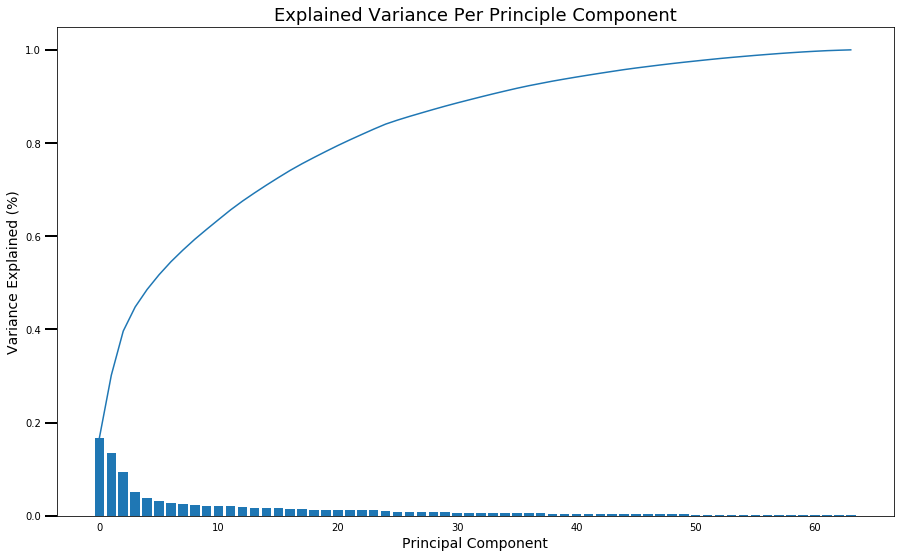

In [67]:
scree_plot(pca)

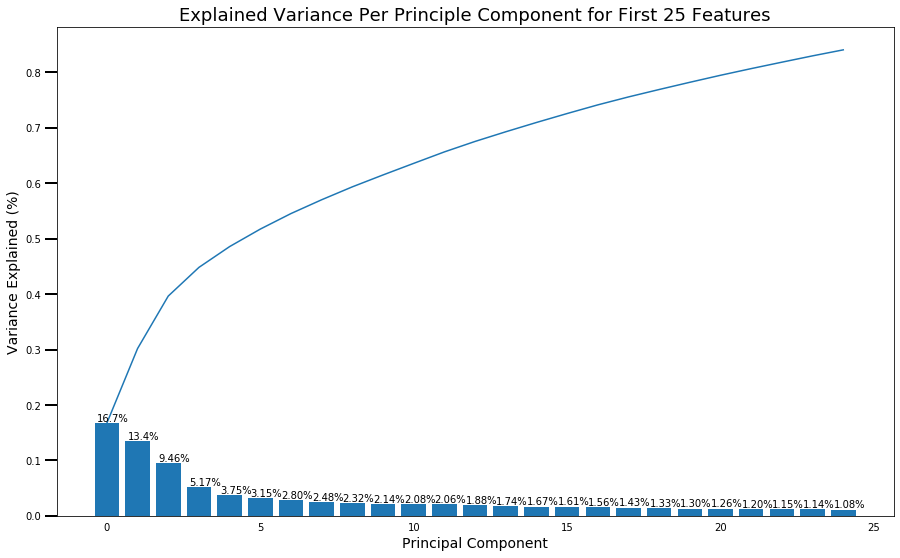

In [68]:
scree_plot(pca, annotate=True, limit=25)

In [69]:
# Calculate variance for first 25 principal components
number_principal_components = 25
pca.explained_variance_ratio_[:number_principal_components].sum()

0.8406460479938205

In [70]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=number_principal_components)
azdias_pca = pca.fit_transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

**Answer:**

After looking at the variance explained by each component in a scree plot, I decided to retain only the top 25 components.
Those components represent a cumulative variance of 84% of the data.

The cleaned dataset contained 64 features, so it represents a dimensionality reduction of 60.94%, only the 39.06% of the features were retained.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [71]:
# Map weights for the principal components to corresponding feature names
def pca_weights_mapping(pca, principal_component_number):
    df = pd.DataFrame(pca.components_, columns=list(azdias_scaled.columns))
    weights = df.iloc[principal_component_number-1].sort_values(ascending=False)
    return weights

In [72]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

pca_weights_1 = pca_weights_mapping(pca, 1)
pca_weights_1

PLZ8_ANTG3                0.227666
PLZ8_ANTG4                0.220790
CAMEO_INTL_2015_WEALTH    0.207324
HH_EINKOMMEN_SCORE        0.203198
ORTSGR_KLS9               0.199347
                            ...   
KBA05_GBZ                -0.217169
FINANZ_MINIMALIST        -0.218660
KBA05_ANTG1              -0.223590
PLZ8_ANTG1               -0.227508
MOBI_REGIO               -0.243279
Name: 0, Length: 64, dtype: float64

In [73]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weights_2 = pca_weights_mapping(pca, 2)
pca_weights_2

ALTERSKATEGORIE_GROB                0.260392
FINANZ_VORSORGER                    0.233275
SEMIO_ERL                           0.230793
SEMIO_LUST                          0.184100
RETOURTYP_BK_S                      0.163939
                                      ...   
SEMIO_PFLICHT                      -0.227808
SEMIO_TRADV                        -0.231684
FINANZ_SPARER                      -0.235985
PRAEGENDE_JUGENDJAHRE_GENERATION   -0.252307
SEMIO_REL                          -0.254404
Name: 1, Length: 64, dtype: float64

In [74]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weights_3 = pca_weights_mapping(pca, 3)
pca_weights_3

SEMIO_VERT           0.345482
SEMIO_SOZ            0.262080
SEMIO_FAM            0.250199
SEMIO_KULT           0.235246
FINANZ_MINIMALIST    0.156211
                       ...   
SEMIO_RAT           -0.218217
SEMIO_KRIT          -0.276055
SEMIO_DOM           -0.315117
SEMIO_KAEM          -0.337648
ANREDE_KZ           -0.368936
Name: 2, Length: 64, dtype: float64

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

**Answer:**
Principal components observations:
 
The first principal component has a positive association with:

 * PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region (higher is higher share)                        
 * PLZ8_ANTG4: Number of 10+ family houses in the PLZ8 region (higher is higher share)
 * CAMEO_INTL_2015_wealth: Household wealth (higher is lower income)

and a negative association with:

 * KBA05_ANTG1: Number of 1-2 family houses in the microcell (higher is higher share of 1-2 family homes in cell)
 * PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region (higher is higher share)
 * MOBI_REGIO: Movement patterns (higher is lower movement)
 
It appears that the first component is related to the household wealth, movement, and share of family homes.

The second principal component has a positive association with:

* ALTERSKATEGORIE_GROB: Estimated age (higher is older)
* FINANZ_VORSORGER: Financial typology, be prepared (higher is lower topology)
* SEMIO_ERL: Personality typology, event-oriented (higher is lower affinity)

And a negative association with:

* SEMIO_REL: Personality typology, religious (higher is lower affinity)
* PRAEGENDE_JUGENDJAHRE_GENERATION: Generation of movement of person's youth (highest is 90s)
* FINANZ_SPARER: Financial typology, money-saver (higher is lower topology)

It seems like the second component is linked to age, decade of movement, and financial savings.

The third principal component has a positive association with:

* SEMIO_VERT: Personality typology, dreamful (higher is lower affinity)
* SEMIO_SOZ: Personality typology, socially-minded (higher is lower affinity)
* SEMIO_FAM: Personality typology, family-minded (higher is lower affinity)

And a negative association with:

* ANREDE_KZ: Gender (2 is female)
* SEMIO_KAEM: Personality typology, combative attitude (higher is lower affinity)
* SEMIO_DOM: Personality typology, dominant-minded (higher is lower affinity)

It looks like the third component is related to the personaly traits and gender.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [75]:
# Obtain k-means score
def k_mean_score(data, center):
    kmeans = KMeans(n_clusters = center)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

In [76]:
# Over a number of different cluster counts...
# run k-means clustering on the data
# compute the average within-cluster distances.

sse = []

# Values of k
k_range = np.arange(1, 25, 2)

# Run over a number of different clusters
for k in k_range:
    # run k-means clustering on the data 
    sse.append(k_mean_score(azdias_pca, k))

Text(0.5, 1.0, 'SSE vs. K')

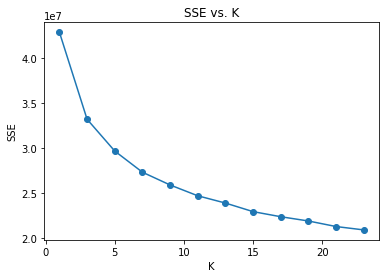

In [77]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(k_range, sse, linestyle='-', marker='o')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')

In [78]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# K value (elbow) choosen based on plot above
k = 15

kmeans = KMeans(n_clusters = k).fit(azdias_pca)
azdias_pred = kmeans.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

**Answer:**

From the above plot, it looks like K=15 is the elbow. Therefore, I decided to use 15 clusters to segment the population.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [79]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [80]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [81]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean = clean_data(customers)

# Apply feature scaling onto the customer data
customers_clean_scaled = feature_scaling(customers_clean)

# PCA transformation
customers_pca = pca.transform(customers_clean_scaled)

C:\Users\luvalverde\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\luvalverde\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
C:\Users\luvalverde\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [82]:
# Predict using Kmeans model 
customers_pred = kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5, 1.0, 'General Clusters')

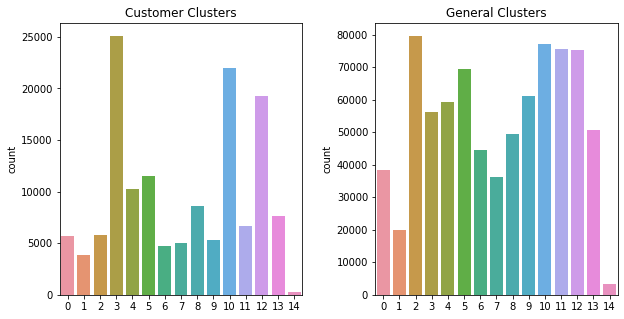

In [83]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
figure.subplots_adjust(hspace = 1, wspace=.3)

sns.countplot(customers_pred, ax=axs[0])
axs[0].set_title('Customer Clusters')

sns.countplot(azdias_pred, ax=axs[1])
axs[1].set_title('General Clusters')

In [84]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

centroid_12 = scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_[12]))

overrepresented_c = pd.Series(data = centroid_12, index = customers_clean.columns)

overrepresented_c

PLZ8_HHZ               3.729464
WOHNDAUER_2008         8.764550
ANZ_HAUSHALTE_AKTIV    3.963074
SEMIO_TRADV            2.226648
SEMIO_KRIT             3.096994
                         ...   
OST_WEST_KZ            0.090560
FINANZ_VORSORGER       5.015432
ARBEIT                 3.267788
ANZ_HH_TITEL           0.049539
GEBAEUDETYP_RASTER     3.740149
Length: 64, dtype: float64

In [85]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

centroid_13 = scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_[13]))

underrepresented_c = pd.Series(data = centroid_13, index = customers_clean.columns)

underrepresented_c

PLZ8_HHZ               3.739158
WOHNDAUER_2008         8.998935
ANZ_HAUSHALTE_AKTIV   -1.221931
SEMIO_TRADV            2.200660
SEMIO_KRIT             5.024570
                         ...   
OST_WEST_KZ            0.001051
FINANZ_VORSORGER       5.071139
ARBEIT                 2.664342
ANZ_HH_TITEL           0.016020
GEBAEUDETYP_RASTER     4.069859
Length: 64, dtype: float64

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

**Answer:**
From the anaylsis above, it can be seen that:

Cluster 12 is overrepresented in the customers data compared to general population data. Some characteristics of the group of population that are relative popular with the mail-order company:

- in areas where the share of 6-10 family homes is lower (PLZ8_ANTG3=0.987274)
- in Prosperous or Comfortable households (CAMEO_INTL_2015_WEALTH=1.431738)
- in life stage of Families With School Age Children or Older Families & Mature Couples (CAMEO_INTL_2015_LIFESTAGE=4.038620)

Cluster 13 is underrepresented in the customers data. Some characteristics of the segment of the population that are relatively unpopular with the company:

- in areas where the share of 6-10 family homes is higher (PLZ8_ANTG3=1.432236)
- in Less Affluent or Poorer households (CAMEO_INTL_2015_WEALTH=2.890910)
- in life stage of Pre-Family Couples & Singles or Young Couples With Children (CAMEO_INTL_2015_LIFESTAGE=3.215712)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.